In [34]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

In [45]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gosia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gosia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gosia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Gosia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [46]:
spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

C:\Users\Gosia\AppData\Local\Temp\ipykernel_27476\699829373.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])


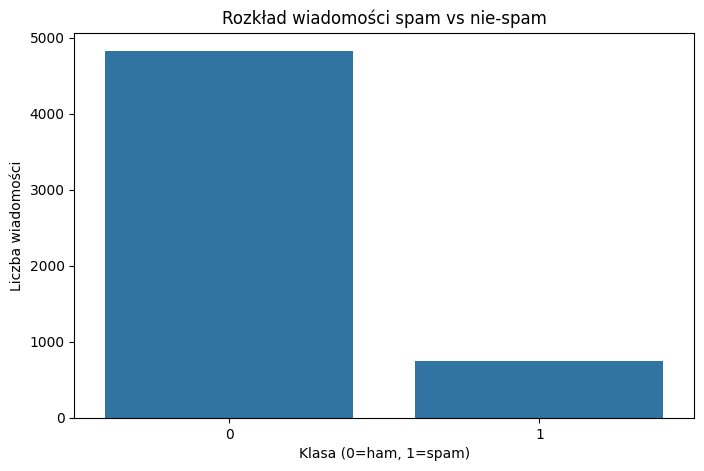

In [35]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Spam', data=spam_dataset)
plt.title('Rozkład wiadomości spam vs nie-spam')
plt.xlabel('Klasa (0=ham, 1=spam)')
plt.ylabel('Liczba wiadomości')
plt.show()

In [47]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

In [48]:
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(
    lambda x: x.lower().split()
)

In [50]:
stopwords_eng = stopwords.words("english")
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords_eng]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

In [52]:
lemmater = WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

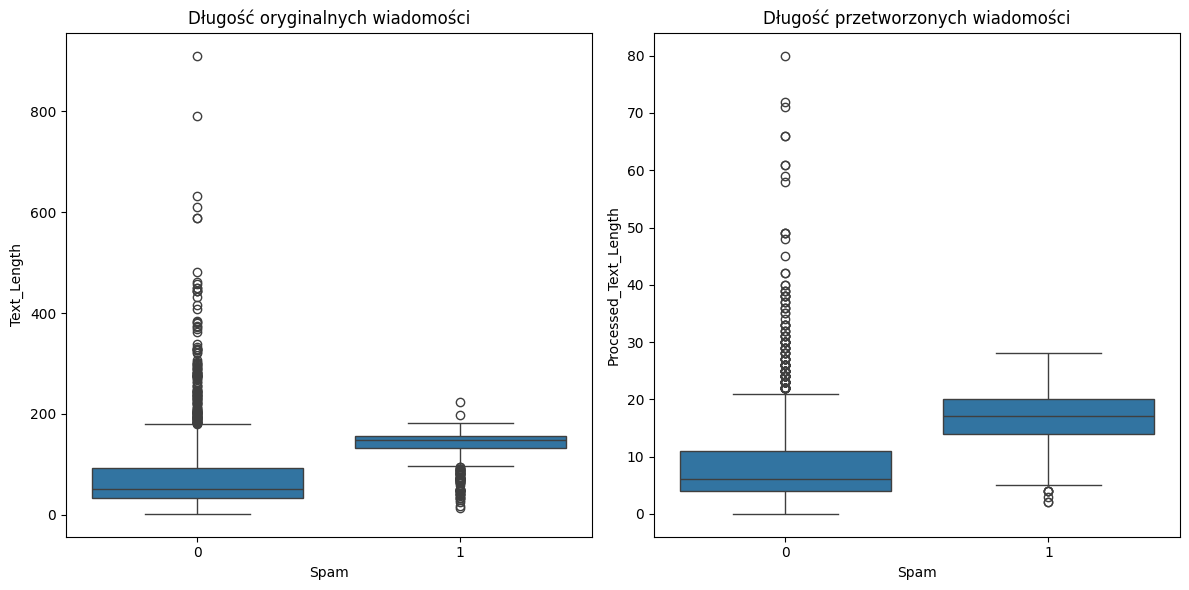

In [53]:
spam_dataset['Text_Length'] = spam_dataset['Text'].apply(len)
spam_dataset['Processed_Text_Length'] = spam_dataset['Lemmatized_Text'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Spam', y='Text_Length', data=spam_dataset)
plt.title('Długość oryginalnych wiadomości')
plt.subplot(1, 2, 2)
sns.boxplot(x='Spam', y='Processed_Text_Length', data=spam_dataset)
plt.title('Długość przetworzonych wiadomości')
plt.tight_layout()
plt.show()

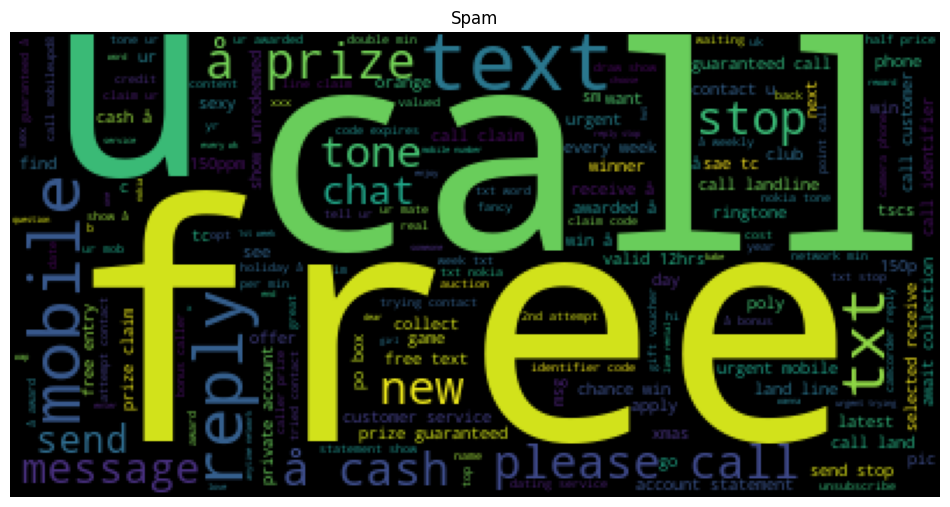

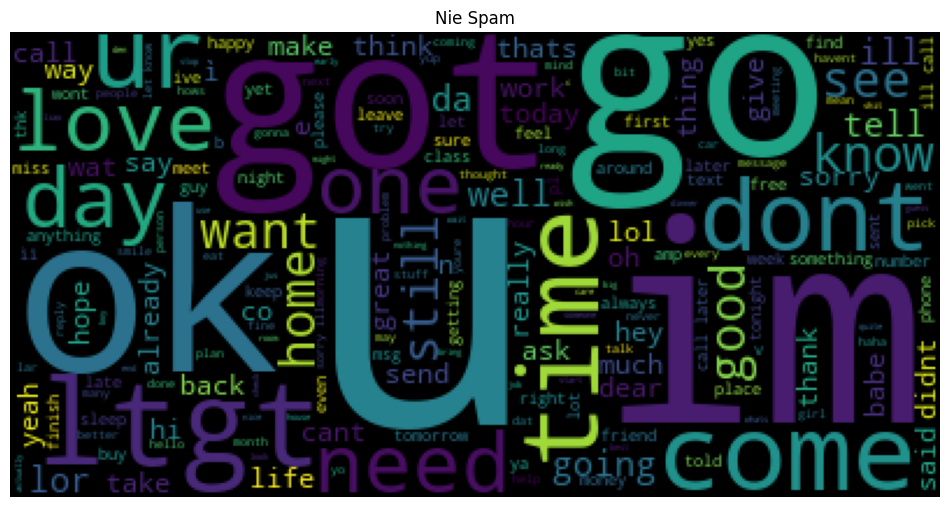

In [54]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)

words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

wordcloud_spam = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.title('Spam')
plt.show()

wordcloud_notspam = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_notspam)
plt.axis("off")
plt.title('Nie Spam')
plt.show()


In [55]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
y = spam_dataset['Spam']

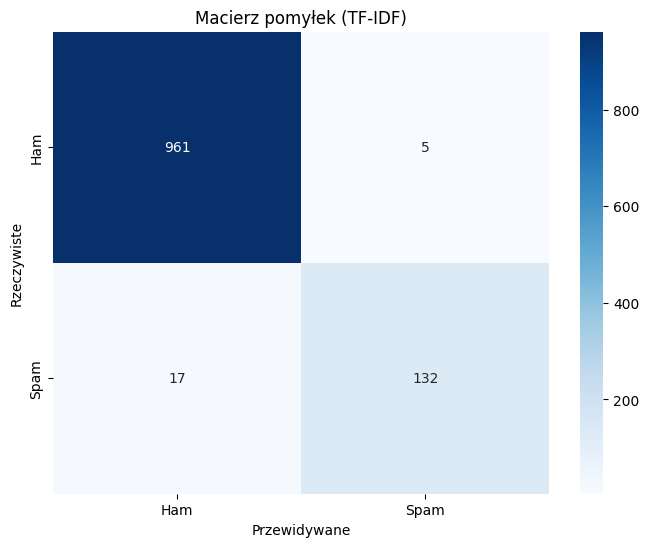

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title('Macierz pomyłek (TF-IDF)')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')
plt.show()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
rf_initial = RandomForestClassifier(random_state=42)
rf_initial.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
feature_importance = rf_initial.feature_importances_

In [60]:
feature_names = tfidf.get_feature_names_out()
importance_dict = dict(zip(feature_names, feature_importance))

In [61]:
selected_features = [feature for feature, importance in importance_dict.items() if importance > 0.001]

In [62]:
selected_feature_indices = [i for i, feature in enumerate(feature_names) if feature in selected_features]

C:\Users\Gosia\AppData\Local\Temp\ipykernel_27476\1204267842.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance, y=top_features, palette='viridis')


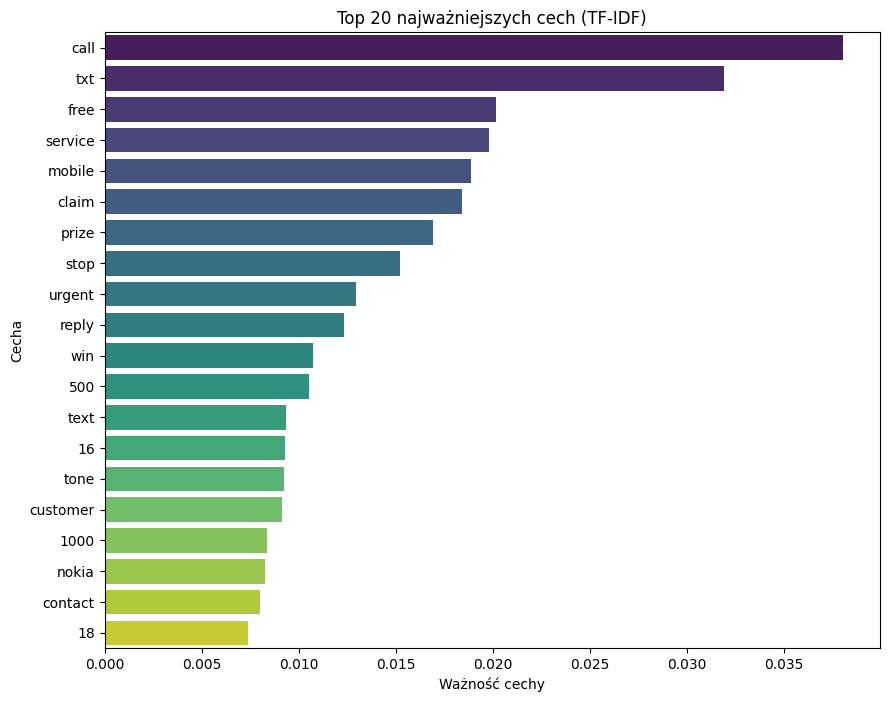

In [63]:
top_n = 20
sorted_indices = np.argsort(feature_importance)[::-1][:top_n]
top_features = [feature_names[i] for i in sorted_indices]
top_importance = feature_importance[sorted_indices]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_importance, y=top_features, palette='viridis')
plt.title(f'Top {top_n} najważniejszych cech (TF-IDF)')
plt.xlabel('Ważność cechy')
plt.ylabel('Cecha')
plt.show()

In [64]:
X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]
print(f"Liczba cech przed selekcją: {X_train.shape[1]}")
print(f"Liczba cech po selekcji: {X_train_selected.shape[1]}")

Liczba cech przed selekcją: 8847
Liczba cech po selekcji: 164


In [66]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', None]
}

In [67]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, 
                           scoring='accuracy',
                           n_jobs=-1,  
                           verbose=1)


In [68]:
grid_search.fit(X_train_selected, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [69]:
best_params = grid_search.best_params_
print(f"Najlepsze hiperparametry znalezione przez GridSearchCV: {best_params}")

Najlepsze hiperparametry znalezione przez GridSearchCV: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [70]:
best_rf_model = grid_search.best_estimator_

In [71]:
accuracy = best_rf_model.score(X_test_selected, y_test)
print(f"Dokładność najlepszego modelu na zbiorze testowym: {accuracy:.4f}")

Dokładność najlepszego modelu na zbiorze testowym: 0.9803


In [72]:
y_pred = best_rf_model.predict(X_test_selected)

In [73]:
print("\nRaport Klasyfikacji na zbiorze testowym:")
print(classification_report(y_test, y_pred))


Raport Klasyfikacji na zbiorze testowym:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [74]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.5)
X_count = count_vectorizer.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, y, test_size=0.2, random_state=42, stratify=y)


In [75]:
rf_count = RandomForestClassifier(random_state=42, **best_params) 
rf_count.fit(X_train_count, y_train_count)
accuracy_count = rf_count.score(X_test_count, y_test_count)
print(f"\nDokładność modelu Random Forest z CountVectorizer na zbiorze testowym: {accuracy_count:.4f}")


Dokładność modelu Random Forest z CountVectorizer na zbiorze testowym: 0.9749


In [76]:
y_pred_count = rf_count.predict(X_test_count)
print("\nRaport Klasyfikacji dla CountVectorizer na zbiorze testowym:")
print(classification_report(y_test_count, y_pred_count))


Raport Klasyfikacji dla CountVectorizer na zbiorze testowym:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.94      0.87      0.90       149

    accuracy                           0.97      1115
   macro avg       0.96      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115



C:\Users\Gosia\AppData\Local\Temp\ipykernel_27476\830003620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='rocket')


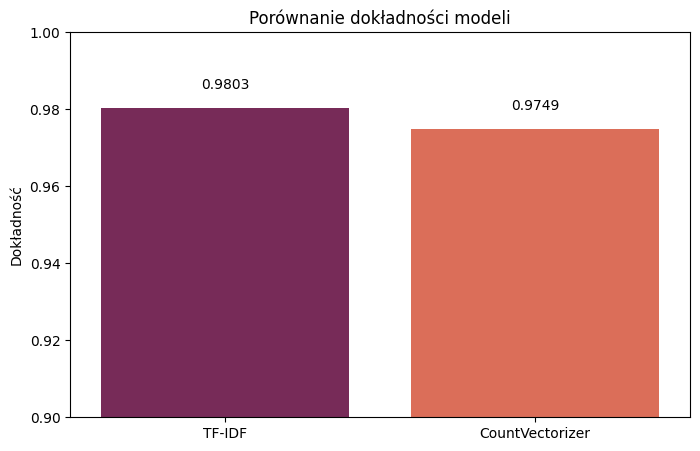

In [77]:
models = ['TF-IDF', 'CountVectorizer']
accuracies = [accuracy, accuracy_count]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='rocket')
plt.ylim(0.9, 1.0)
plt.title('Porównanie dokładności modeli')
plt.ylabel('Dokładność')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.show()